### <h1><center><font color='orange'><b>COMPUTER VISION EXERCISE<font></a>

In [ ]:
!pip install open3d

### Load and visualize the data Libraries

To view the amplitude, distance and cloud point data, we will use matlplotlib

In [7]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage import gaussian_filter, median_filter
from scipy.ndimage.morphology import binary_opening, binary_closing
from scipy.ndimage import label, sobel
from scipy.spatial import ConvexHull
from skimage import io, measure


C:\Users\Dell XPS 9380\AppData\Local\Temp\ipykernel_7496\3450629311.py:10: DeprecationWarning: Please use `binary_opening` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_opening, binary_closing
C:\Users\Dell XPS 9380\AppData\Local\Temp\ipykernel_7496\3450629311.py:10: DeprecationWarning: Please use `binary_closing` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_opening, binary_closing


In [8]:
data = scipy.io.loadmat("data/example1kinect.mat")

In [9]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])


In [10]:
def visualize_image(image, title="Image", cmap='gray'):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.colorbar(label=title)
    plt.show()

In [11]:
print(data['amplitudes1'].shape)
print(data['distances1'].shape)
print(data['cloud1'].shape)


(424, 512)
(424, 512)
(424, 512, 3)


In [13]:
distances1 = data['distances1']
cv.imshow("Distances_View" , distances1)
cv.waitKey(0)


-1

In [6]:
amplitudes1 = data['amplitudes1']
cv.imshow("Amplitudes_View" , amplitudes1)
cv.waitKey(0)


-1

In [9]:
cloud1 = data['cloud1']
cv.imshow("Cloud_View" , cloud1)
cv.waitKey(0)


-1

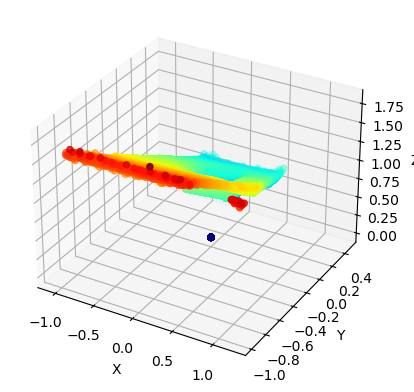

In [10]:
cloud1 = data['cloud1']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


x_coords = cloud1[:, :, 0]  
y_coords = cloud1[:, :, 1]  
z_coords = cloud1[:, :, 2] 


x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
z_flat = z_coords.flatten()


ax.scatter(x_flat, y_flat, z_flat, c=z_flat, cmap='jet', marker='o')

# Labels and axis settings
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Show the plot
plt.show()

In [11]:
# Apply Gaussian smoothing (blur) to reduce noise
smoothed_distances = gaussian_filter(distances1, sigma=0.3)
cv.imshow("Smoothed Distances (Gaussian)", smoothed_distances)
cv.waitKey(0)


-1

In [13]:
# Apply Median filter to remove salt-and-pepper noise
median_distances = median_filter(distances1, size=3)
cv.imshow("Median Filtered Distances", median_distances)
cv.waitKey(0)

-1

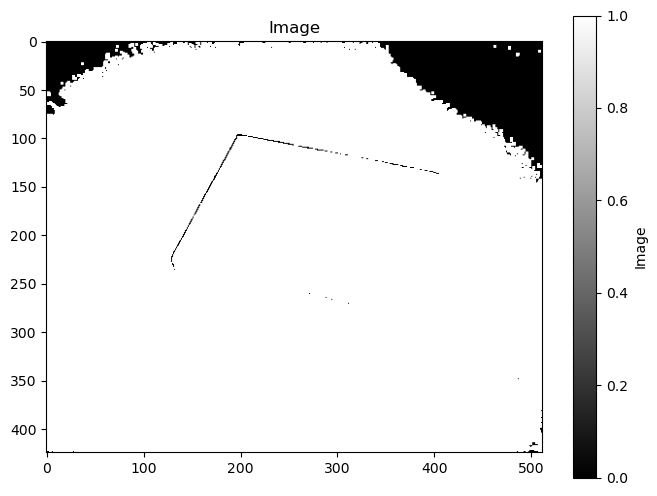

Shouldn't be used, it's not giving good results


In [12]:
# closed_distances = binary_closing(distances1, structure=np.ones((3,3))).astype(np.uint8)
# cv.imshow("Morphological Closing", closed_distances)
# cv.waitKey(0)

opened_distances = binary_opening(distances1, structure=np.ones((3,3))).astype(np.uint8)
visualize_image(opened_distances)
print("Shouldn't be used, it's not giving good results")

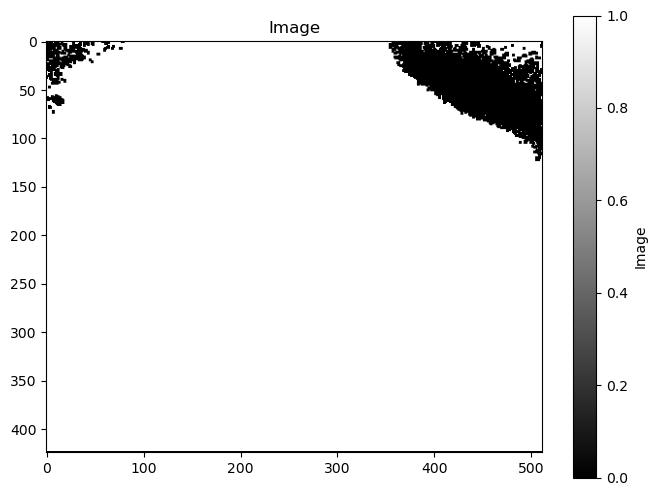

Shouldn't be used, it's not giving good results


In [13]:
# Apply morphological closing to fill small holes
closed_distances = binary_closing(distances1, structure=np.ones((3,3))).astype(np.uint8)
visualize_image(closed_distances)
print("Shouldn't be used, it's not giving good results")


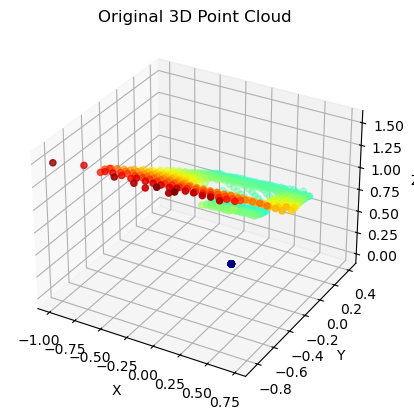

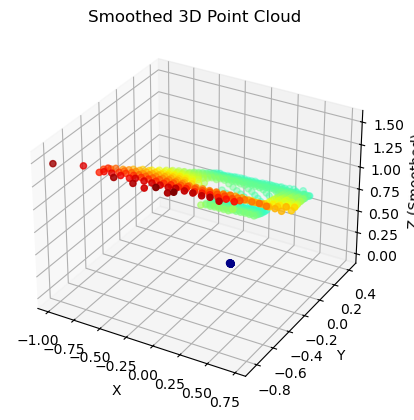

The gaussian filter was applied with various values of sigma. The filter gave the best results for sigma= 0.3. It smooths the data without overly distorting or removing key structural information.


In [14]:
downsample_size = 20

x_coords = cloud1[::downsample_size, ::downsample_size, 0]
y_coords = cloud1[::downsample_size, ::downsample_size, 1]
z_coords = cloud1[::downsample_size, ::downsample_size, 2]
x_flat = x_coords.flatten()
y_flat = y_coords.flatten()
z_flat = z_coords.flatten()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_flat, y_flat, z_flat, c=z_flat, cmap='jet', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Original 3D Point Cloud')
plt.show()

sigma = 0.3

z_smoothed = gaussian_filter(z_coords, sigma=sigma)
x_smoothed = gaussian_filter(x_coords, sigma=sigma)
y_smoothed = gaussian_filter(y_coords, sigma=sigma)

z_flat_smoothed = z_smoothed.flatten()
x_flat_smoothed = x_smoothed.flatten()
y_flat_smoothed = y_smoothed.flatten()


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_flat_smoothed, y_flat_smoothed, z_flat_smoothed, c=z_flat_smoothed, cmap='jet', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Smoothed)')
plt.title('Smoothed 3D Point Cloud')
plt.show()

print("The gaussian filter was applied with various values of sigma. The filter gave the best results for sigma= 0.3. It smooths the data without overly distorting or removing key structural information.")

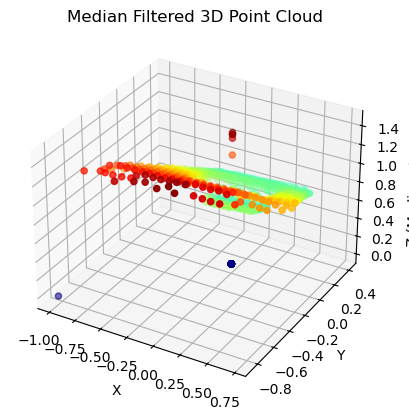

The Median filter removes outliers quite well, but it seems to be over-aggressive in some areas


In [15]:
z_median_filtered = median_filter(z_coords, size=3)
z_flat_median = z_median_filtered.flatten()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_flat, y_flat, z_flat_median, c=z_flat_median, cmap='jet', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (Median Filtered)')
plt.title('Median Filtered 3D Point Cloud')
plt.show()

print("The Median filter removes outliers quite well, but it seems to be over-aggressive in some areas")

### Implementation of RANSAC Algorithm

### Steps of the RANSAC Algorithm
##### 1. Random Sampling:

Randomly select a minimal subset of data points needed to estimate the model parameters.
For example, if you're trying to fit a plane in 3D space, you would select 3 points (since 3 points define a plane).

##### 2. Model Fitting:

Using the randomly selected points, fit the model (e.g., find the equation of the plane).

##### 3. Inlier Counting:

Check which points from the dataset fit the model within a predefined threshold (i.e., are close to the model).
These points are considered inliers.

##### 4. Iteration:

Repeat the process for a set number of iterations or until a sufficiently good model is found.
In each iteration, a new random subset of points is selected, and a new model is fitted.
##### 5. Best Model Selection:

The model with the largest number of inliers is chosen as the best model.

##### 6. Final Model Fitting:

Once the best inlier set is identified, the model is re-fitted using all the inliers to get a more accurate model.

In [14]:
def ransac_plane_detection(points, threshold=0.01, max_iterations=1000):
    best_model = None
    max_inliers = 0
    best_inlier_points = None
    num_points = points.shape[0]

    for i in range(max_iterations):
        idx = np.random.choice(num_points, 3, replace=False)
        sample_points = points[idx]
        
        p1, p2, p3 = sample_points
        normal = np.cross(p2 - p1, p3 - p1)
        norm_value = np.linalg.norm(normal)
        
        if norm_value == 0:
            continue  
        
        normal = normal / norm_value  
        d = -np.dot(normal, p1)
        distances = np.abs(np.dot(points, normal) + d) / norm_value
        inliers = points[distances < threshold]
        
        if inliers.shape[0] > max_inliers:
            max_inliers = inliers.shape[0]
            best_model = (normal, d)
            best_inlier_points = inliers
    
    return best_model, best_inlier_points

### Floor Detection using RANSAC Algorithm

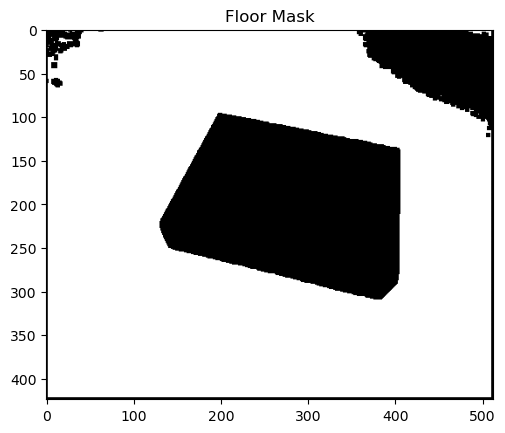

In [18]:
z_coords_smoothed = gaussian_filter(cloud1[:, :, 2], sigma=0.3)

cloud1 = data['cloud1']  
x_coords = cloud1[:, :, 0].flatten()
y_coords = cloud1[:, :, 1].flatten()
z_coords_smoothed_flat = z_coords_smoothed.flatten()

valid_mask = z_coords_smoothed_flat != 0
valid_points = np.column_stack((x_coords[valid_mask], y_coords[valid_mask], z_coords_smoothed_flat[valid_mask]))

threshold_value = 0.1  
max_iterations_value = 1000 

floor_plane_model, num_inliers = ransac_plane_detection(valid_points, threshold=threshold_value, max_iterations=max_iterations_value)

normal, d = floor_plane_model
distances = np.abs(np.dot(valid_points, normal) + d) / np.linalg.norm(normal)
floor_inlier_mask = distances < threshold_value 

floor_mask = np.zeros(cloud1.shape[:2], dtype=bool)  # Shape: (424, 512) 

floor_mask[valid_mask.reshape(cloud1.shape[:2])] = floor_inlier_mask #True 1 for pixels belonging to floor
refined_floor_mask = binary_closing(floor_mask, structure=np.ones((5,5)))


plt.imshow(refined_floor_mask, cmap='gray')
plt.title('Floor Mask')
plt.show()


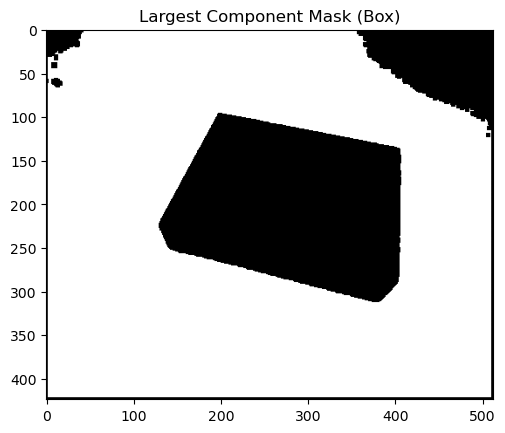

In [18]:
labeled_mask_floor, num_features_floor = label(refined_floor_mask)

component_sizes = np.bincount(labeled_mask_floor.ravel())
component_sizes[0] = 0

largest_component_label = component_sizes.argmax()

box_mask = (labeled_mask_floor == largest_component_label)

plt.imshow(box_mask, cmap='gray')
plt.title('Largest Component Mask (Box)')
plt.show()

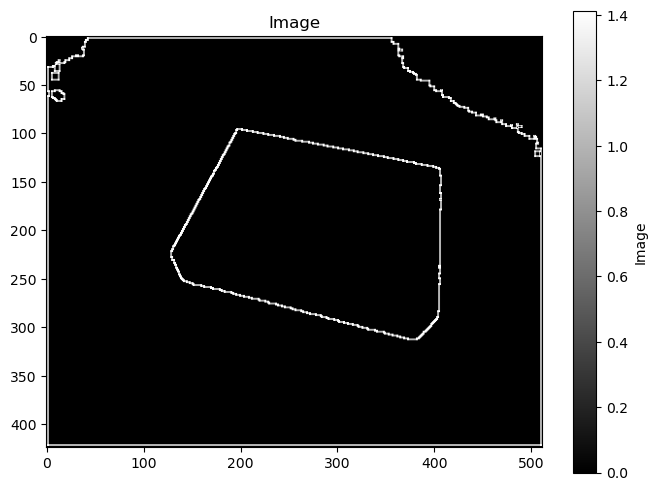

In [19]:
dx_floor = sobel(box_mask, axis=0)  # Horizontal gradient
dy_floor = sobel(box_mask, axis=1)

edges_floor = np.hypot(dx_floor, dy_floor)
visualize_image(edges_floor)

### Top Plane Detection

In [22]:
def detect_box_plane(point_cloud, floor_mask):
    non_floor_points = point_cloud[~floor_mask]
    
    box_plane, inliers = ransac_plane_detection(non_floor_points)
    
    return box_plane, inliers


In [23]:
box_plane_model, box_inliers = detect_box_plane(cloud1, refined_floor_mask)

print("Detected Box Plane Model:", box_plane_model)
print("Number of Box Inliers:", len(box_inliers))


Detected Box Plane Model: (array([-0.42673948,  0.8958538 ,  0.12385223]), -0.0)
Number of Box Inliers: 15950


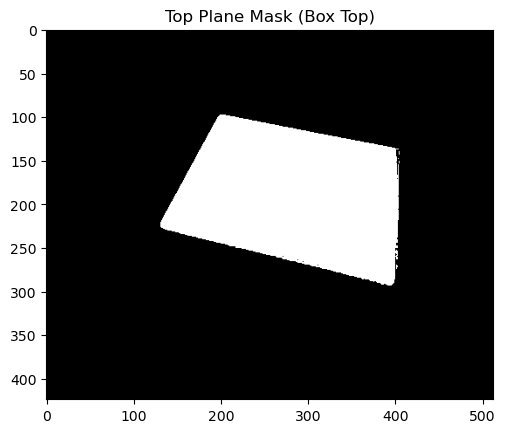

In [24]:
non_floor_mask = ~refined_floor_mask[valid_mask.reshape(cloud1.shape[:2])].flatten()
non_floor_points = valid_points[non_floor_mask]

top_plane_model, top_inliers = ransac_plane_detection(non_floor_points)

normal_top, d_top = top_plane_model
distances_top = np.abs(np.dot(non_floor_points, normal_top) + d_top) / np.linalg.norm(normal_top)
top_inlier_mask = distances_top <0.01 # Threshold for the top plane (same as floor threshold)


top_plane_mask = np.zeros(cloud1.shape[:2], dtype=bool)

valid_mask_reshaped = valid_mask.reshape(cloud1.shape[:2])

top_plane_mask[valid_mask_reshaped] = False  # Set the default to False
top_plane_mask[valid_mask_reshaped & ~refined_floor_mask] = top_inlier_mask

plt.imshow(top_plane_mask, cmap='gray')
plt.title('Top Plane Mask (Box Top)')
plt.show()


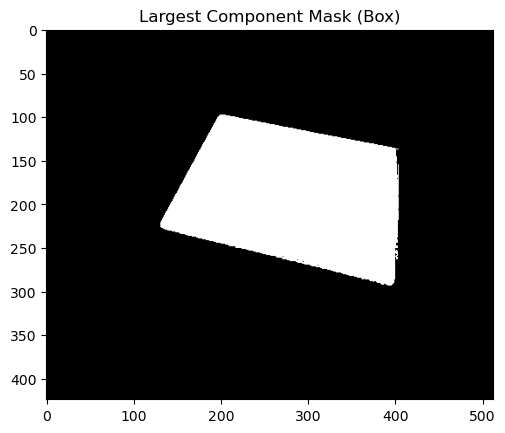

In [25]:
labeled_mask, num_features = label(top_plane_mask)

component_sizes = np.bincount(labeled_mask.ravel())
component_sizes[0] = 0

largest_component_label = component_sizes.argmax()

box_mask = (labeled_mask == largest_component_label)

plt.imshow(box_mask, cmap='gray')
plt.title('Largest Component Mask (Box)')
plt.show()

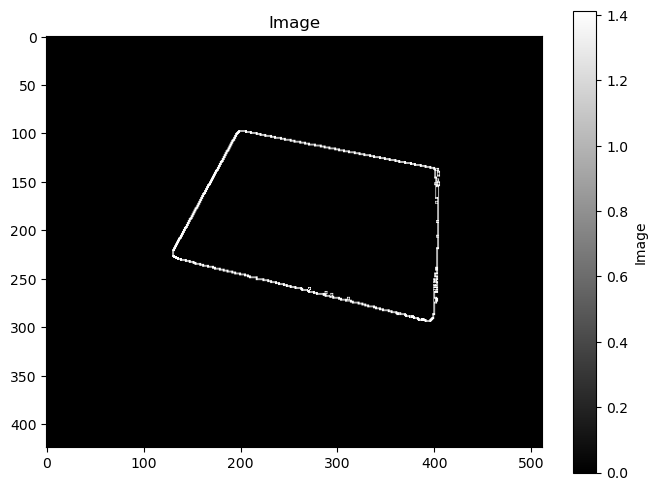

In [26]:
dx = sobel(top_plane_mask, axis=0)  # Horizontal gradient
dy = sobel(top_plane_mask, axis=1)

edges = np.hypot(dx, dy)
visualize_image(edges)

#from scipy.ndimage import sobel, binary_opening
# visualize_image(cleaned_mask)

### Measuring the Dimensions of the Box

In [27]:
def find_and_return_corners(binary_image, num_corners = 4, plot=True):
    contours = measure.find_contours(binary_image, level=0.8)
    largest_contour = max(contours, key=len)
    hull = ConvexHull(largest_contour)
    hull_points = largest_contour[hull.vertices]
    contour_for_approx = np.array(largest_contour, dtype=np.float32)
    epsilon = 0.02 * cv.arcLength(contour_for_approx, True)  # Parameter to control approximation accuracy
    approx_corners = cv.approxPolyDP(contour_for_approx, epsilon, True)

    if len(approx_corners) > num_corners:
        approx_corners = approx_corners[:4]

    corners = np.squeeze(approx_corners)
    
    if plot == True:
        fig, ax = plt.subplots()
        ax.imshow(binary_image, cmap=plt.cm.gray)
        ax.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2)
        plt.show()
        fig, ax = plt.subplots()
        ax.imshow(binary_image, cmap=plt.cm.gray)
        ax.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2, label='Contour')
        ax.plot(corners[:, 1], corners[:, 0], 'go', label='Corners')
        ax.legend()
        plt.show()
    
    return corners[:, [1, 0]]

#### Top Edges

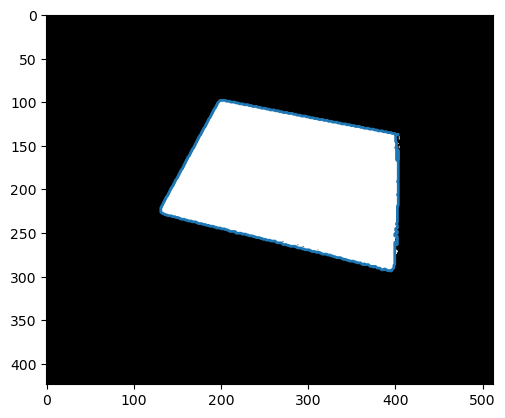

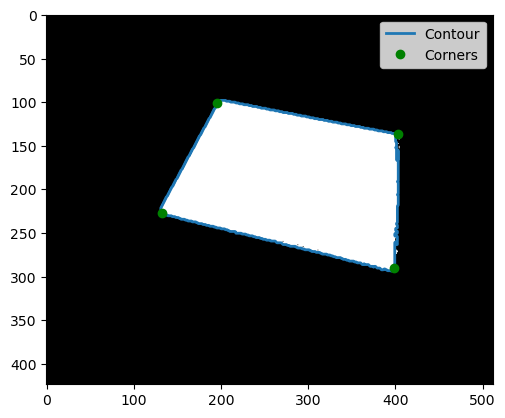

[[398.2 290. ]
 [132.  227.2]
 [195.8 101. ]
 [403.  136.8]]


In [28]:
#binary_image = edges
corners_top = find_and_return_corners(top_plane_mask)
print(corners_top)

# corners_top, countours_top = find_and_return_corners(top_plane_mask)
# print(corners_top)

#### Floor Edges

In [29]:
def find_and_return_corners_floor(binary_image, num_corners = 4, plot=True):
    contours = measure.find_contours(binary_image, level=0.8)
    largest_contour = max(contours, key=len)
    hull = ConvexHull(largest_contour)
    hull_points = largest_contour[hull.vertices]
    contour_for_approx = np.array(largest_contour, dtype=np.float32)
    epsilon = 0.09 * cv.arcLength(contour_for_approx, True)  # Parameter to control approximation accuracy
    approx_corners = cv.approxPolyDP(contour_for_approx, epsilon, True)

    if len(approx_corners) > num_corners:
        approx_corners = approx_corners[:4]

    corners = np.squeeze(approx_corners)
    
    if plot == True:
        fig, ax = plt.subplots()
        ax.imshow(binary_image, cmap=plt.cm.gray)
        ax.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2)
        plt.show()
        fig, ax = plt.subplots()
        ax.imshow(binary_image, cmap=plt.cm.gray)
        ax.plot(largest_contour[:, 1], largest_contour[:, 0], linewidth=2, label='Contour')
        ax.plot(corners[:, 1], corners[:, 0], 'go', label='Corners')
        ax.legend()
        plt.show()
    
    return corners[:, [1, 0]]

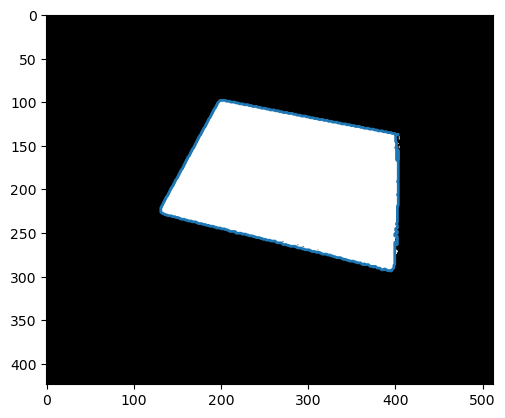

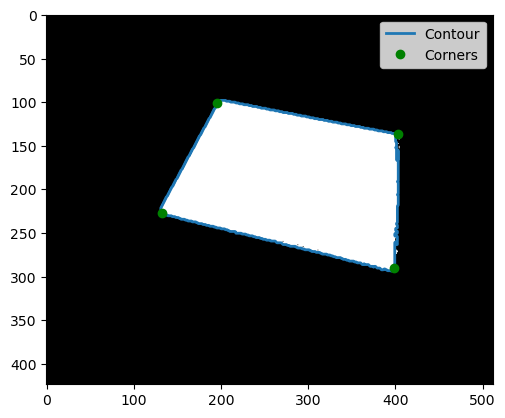

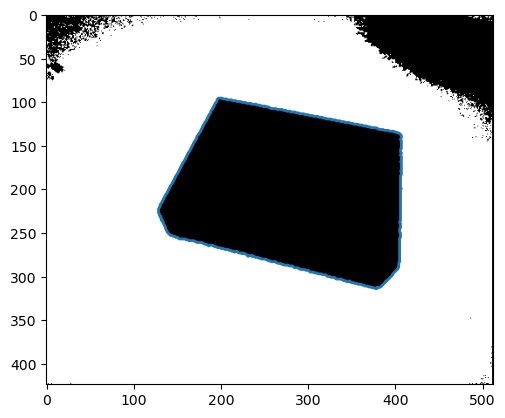

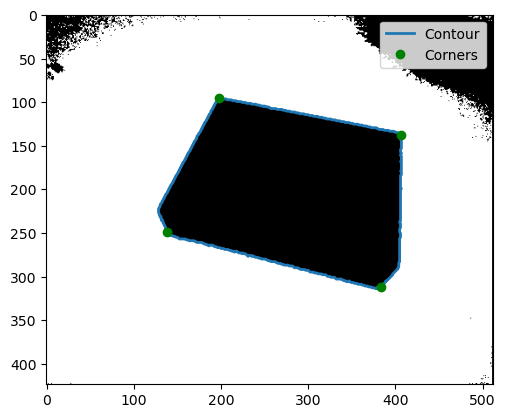

Top Corners: [[398.2 290. ]
 [132.  227.2]
 [195.8 101. ]
 [403.  136.8]]
Floor Corners: [[383.  311.8]
 [406.8 138. ]
 [197.   95.2]
 [138.2 249. ]]


In [30]:
# dx_floor = sobel(floor_mask, axis=0)  # Horizontal gradient
# dy_floor = sobel(floor_mask, axis=1)  # Vertical gradient 
# edges_floor = np.hypot(dx_floor, dy_floor) 

# dx_top = sobel(top_plane_mask, axis=0)  
# dy_top = sobel(top_plane_mask, axis=1) 
# edges_top = np.hypot(dx_top, dy_top)    

corners_top = find_and_return_corners(top_plane_mask)   
corners_floor  = find_and_return_corners_floor(floor_mask)     

corners_top = corners_top[:4]
corners_floor = corners_floor[:4]


print("Top Corners:", corners_top)
print("Floor Corners:", corners_floor)



#### Length and Width Calculation

In [37]:
top_corners_3d = []
for corner in corners_top:
    x, y = int(corner[0]), int(corner[1]) 
    z = cloud1[y, x, 2]  # Access Z-coordinate from cloud1
    top_corners_3d.append([x, y, z])

top_corners_3d = np.array(top_corners_3d)  


In [36]:
distances = [
    np.linalg.norm(top_corners_3d[0] - top_corners_3d[1]),  # distance between point 0 and 1
    np.linalg.norm(top_corners_3d[1] - top_corners_3d[2]),  # distance between point 1 and 2
    np.linalg.norm(top_corners_3d[2] - top_corners_3d[3]),  # distance between point 2 and 3
    np.linalg.norm(top_corners_3d[3] - top_corners_3d[0])   # distance between point 3 and 0
]

unique_distances = list(set(distances))
length, width = max(unique_distances), min(unique_distances)

print(f"Length: {length}")
print(f"Width: {width}")

Length: 273.3587430484023
Width: 140.87368236837693


#### Height Calculation

In [33]:
def calculate_height(top_corners, floor_corners, cloud):
    top_corners = np.array(corners_top)
    floor_corners = np.array(corners_floor)

    heights = []

   
    for top_point in top_corners:
        distances = np.linalg.norm(floor_corners - top_point, axis=1)
        
        closest_index = np.argmin(distances)
        closest_floor_point = floor_corners[closest_index]
        
        z_top = cloud[int(top_point[1]), int(top_point[0]), 2]
        z_floor = cloud[int(closest_floor_point[1]), int(closest_floor_point[0]), 2]
        
        height = abs(z_top - z_floor)
        heights.append(height)
        
    average_height = np.mean(heights)
    return average_height

box_height = calculate_height(corners_top, corners_floor, cloud1)
print(f"Calculated Box Height: {box_height}")


Calculated Box Height: 0.5355000495910645


In [ ]:
# z_top = [cloud1[int(y), int(x), 2] for x, y in corners_top]
# z_floor = [cloud1[int(y), int(x), 2] for x, y in corners_floor]

# height = np.mean([np.abs(z_top[i] - z_floor[i]) for i in range(len(z_top))])

# print(f"Box height: {height} ")

## RANSAC for Box Detection

1) Detect the floor (we've done this using RANSAC on the point cloud data). The floor is detected as the largest horizontal plane in the point cloud. The RANSAC algorithm effectively filters points below a certain threshold.
2) Filter out the points that belong to the floor. Apply RANSAC again to find the box top. The top of the box is detected as the second largest plane after the floor.
3) Measure the dimensions of the box once you have calculated the top and floor component.

##### Algorithm Weaknesses: 

1) <b>Noise Sensitivity: </b> The current RANSAC implementation may misinterpret noisy points as part of a plane, especially with larger thresholds. Implementing pre-filtering or noise reduction techniques, such as statistical outlier removal can produce better results.
2) <b>Ambiguity in Small Planes:</b> Small planes or parts of the box may not be detected correctly because they might not have enough inliers during RANSAC iterations. We can consider multi-scale RANSAC or boosting the number of inliers required for small regions.
3) <b>Connected Component Segmentation: </b> While the largest connected component is typically the box's top, smaller planes might be misclassified as parts of the sides or box corners.
Suggestion: Perform additional segmentation based on plane orientation (angle) and ensure planar continuity.
4) <b>Sensitivity to Threshold Selection: </b> The inlier threshold is critical for determining which points fit the model well. A threshold that’s too low can result in fewer inliers (missing good points), while a threshold that’s too high can include outliers, reducing model accuracy.
  Suggestion: Dynamic Threshold Adjustment: Use a more adaptive threshold that changes based on the characteristics of the data, such as adjusting the threshold after a certain number of iterations based on the distribution of errors.
5) <b>Computation Cost: </b> RANSAC’s iterative nature means it can be computationally expensive, especially with large datasets. Each iteration involves random sampling, model fitting, and evaluating the number of inliers. As the data size grows or with stricter thresholds for inlier fitting, the time complexity increases substantially.
 Suggestion: Adaptive RANSAC: Stop iterating once a sufficient number of inliers is found, rather than using a fixed number of iterations.

##### Suggested Extensions:
1) <b>Edge Detection:</b> Apply Sobel filters or gradient-based edge detection to enhance the identification of box edges (i.e., corners).
2) <b>Morphological Operations:</b> Further clean up the masks using dilation and erosion to ensure smoother edges.

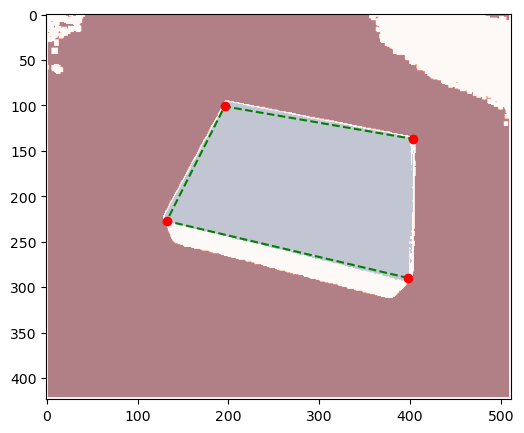

In [35]:
plt.figure(figsize=(6, 6))
plt.imshow(top_plane_mask, cmap="Blues", alpha=0.5)
plt.imshow(refined_floor_mask, cmap="Reds", alpha=0.5)
plt.plot(corners_top[:, 0], corners_top[:, 1], '--g')
plt.plot(corners_top[:, 0], corners_top[:, 1], 'ro')


# def visualize_results(floor_mask, box_top_mask):
#     visual_mask = np.zeros((*floor_mask.shape, 3), dtype=np.uint8)
#     visual_mask[floor_mask] = [0, 255, 0]  # Green for the floor
#     visual_mask[box_top_mask] = [255,0,0]  # Red for the top
#    # visual_mask[box_sides_mask] = [0, 0, 255]  # Blue for the sides

#     plt.imshow(visual_mask)
#     plt.title('Visualization of Floor, Box, and Box Corners')
#     plt.show()

# floor_mask = refined_floor_mask 
# top_plane_mask = top_plane_mask  
# visualize_results(floor_mask, top_plane_mask)
